In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

if "../../" not in sys.path:
    sys.path.append("../../")
    print("[sys.path]:", sys.path)

[sys.path]: ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages', '../../']


In [7]:
from src.data.babel import BabelDataset
from src.data.hml3d import HML3DDataset

/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dataset_classes = {
    "babel": BabelDataset,
    "hml3d": HML3DDataset
}

In [57]:
from notebooks.data.helpers import get_analysis_with_cache

In [60]:
configurations = [
    ("babel", "filtered-locate"),
    ("hml3d", "hml3d")
]

analyses_list = []

for dataset_name, pipeline_name in configurations:
    train_dataset = dataset_classes[dataset_name](
        split="train",
        pipeline=pipeline_name
    )
    print("[train_dataset.fingerprint]:", train_dataset.fingerprint)
    validation_dataset = dataset_classes[dataset_name](
        split="validation",
        pipeline=pipeline_name
    )
    print("[validation_dataset.fingerprint]:", validation_dataset.fingerprint)
    # TODO: add the test split when available

    train_analysis = get_analysis_with_cache(
        dataset=train_dataset,
        dataset_name=dataset_name,
        pipeline_name=pipeline_name,
        split_name="Train"
    )
    train_analysis["split_name"] = "Train"
    train_analysis["dataset_name"] = dataset_name
    validation_analysis = get_analysis_with_cache(
        dataset=validation_dataset,
        dataset_name=dataset_name,
        pipeline_name=pipeline_name,
        split_name="Validation"
    )
    validation_analysis["split_name"] = "Validation"
    validation_analysis["dataset_name"] = dataset_name
    
    analyses_list.append(train_analysis)
    analyses_list.append(validation_analysis)

Repo card metadata block was not found. Setting CardData to empty.


[train_dataset.fingerprint]: 21d5bce1779c5c02


Repo card metadata block was not found. Setting CardData to empty.


[validation_dataset.fingerprint]: 2928b3e14c2ffe6a
[cache]: Loading Train analysis from ./cache.local/babel_filtered-locate_train_21d5bce1779c5c02.pkl
[cache]: Loading Validation analysis from ./cache.local/babel_filtered-locate_validation_2928b3e14c2ffe6a.pkl


Repo card metadata block was not found. Setting CardData to empty.


[train_dataset.fingerprint]: a3e17cf557385989


Repo card metadata block was not found. Setting CardData to empty.


[validation_dataset.fingerprint]: dc711d58aac5e651
[cache]: Loading Train analysis from ./cache.local/hml3d_hml3d_train_a3e17cf557385989.pkl
[cache]: Loading Validation analysis from ./cache.local/hml3d_hml3d_validation_dc711d58aac5e651.pkl


In [61]:
import collections

import numpy as np
import matplotlib.pyplot as plt

In [70]:
def plot_multiple_datasets_spans_overlay(
    analyses_list,
    deciles=[1, 2, 2.5, 3, 4, 5, 6, 7, 7.5, 8, 9, 9.5, 9.75, 9.99], 
    top_n_spans=10,
    figsize=(20, 12)
):
    """
    Plot overlay of span durations from multiple datasets and suggest optimal span sizes.
    
    Args:
        analyses_list: List of analysis dictionaries from different datasets
        deciles: List of decile values to plot
        top_n_spans: Number of most occurring span sizes to highlight
        figsize: Figure size tuple
    """
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Multi-Dataset Span Duration Analysis', fontsize=16)
    
    # Colors for different datasets
    colors = plt.cm.Set1(np.linspace(0, 1, len(analyses_list)))
    
    # Collect all span durations and dataset info
    all_span_durations = {}
    dataset_stats = {}
    
    for i, analysis in enumerate(analyses_list):
        dataset_name = f"{analysis['dataset_name']}_{analysis['split_name']}"
        span_durations = analysis['durations']
        all_span_durations[dataset_name] = span_durations
        
        if span_durations:
            dataset_stats[dataset_name] = {
                'min': np.min(span_durations),
                'max': np.max(span_durations),
                'mean': np.mean(span_durations),
                'median': np.median(span_durations),
                'std': np.std(span_durations),
                'count': len(span_durations),
                'color': colors[i]
            }
    
    # Plot 1: Overlay histograms
    ax1 = axes[0, 0]
    for dataset_name, durations in all_span_durations.items():
        if durations:
            ax1.hist(durations, bins=50, alpha=0.6, label=dataset_name, 
                    color=dataset_stats[dataset_name]['color'], density=True)
    
    ax1.set_title('Span Duration Distribution Overlay (Normalized)')
    ax1.set_xlabel('Duration (frames)')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Box plots comparison
    ax2 = axes[0, 1]
    box_data = []
    box_labels = []
    box_colors = []
    
    for dataset_name, durations in all_span_durations.items():
        if durations:
            box_data.append(durations)
            box_labels.append(dataset_name)
            box_colors.append(dataset_stats[dataset_name]['color'])
    
    bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax2.set_title('Span Duration Box Plots Comparison')
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Duration (frames)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative distribution
    ax3 = axes[1, 0]
    for dataset_name, durations in all_span_durations.items():
        if durations:
            sorted_durations = np.sort(durations)
            cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)
            ax3.plot(sorted_durations, cumulative, label=dataset_name, 
                    color=dataset_stats[dataset_name]['color'], linewidth=2)
    
    ax3.set_title('Cumulative Distribution of Span Durations')
    ax3.set_xlabel('Duration (frames)')
    ax3.set_ylabel('Cumulative Probability')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add decile lines
    for d in deciles:
        ax3.axhline(d/10, color='gray', linestyle='--', alpha=0.5)
        ax3.text(ax3.get_xlim()[1]*0.02, d/10, f'{d*10:.1f}%', 
                verticalalignment='bottom', fontsize=8)
    
    # Plot 4: Most common span sizes analysis
    ax4 = axes[1, 1]
    
    # Combine all durations to find most common spans
    all_durations_combined = []
    for durations in all_span_durations.values():
        all_durations_combined.extend(durations)
    
    if all_durations_combined:
        # Count occurrences of each span duration
        duration_counts = collections.Counter(all_durations_combined)
        most_common_spans = duration_counts.most_common(top_n_spans)
        
        spans, counts = zip(*most_common_spans)
        
        bar_positions = [i * 2.5 for i in range(len(spans))]  # spacing factor (e.g., 1.5)
        bars = ax4.bar(bar_positions, counts, alpha=0.7)
        ax4.set_xticks(bar_positions)
        # bars = ax4.bar(range(len(spans)), counts, alpha=0.7)
        # ax4.set_xticks(range(len(spans)))
        
        ax4.set_title(f'Top {top_n_spans} Most Common Span Durations (All Datasets)')
        ax4.set_xlabel('Span Duration (frames)')
        ax4.set_ylabel('Frequency')
        ax4.set_xticklabels([str(s) for s in spans])
        ax4.grid(True, alpha=0.3)
        
        # Add value labels on bars
        # for i, (span, count) in enumerate(most_common_spans):
        #     ax4.text(i, count + max(counts)*0.01, str(count), 
        #             ha='center', va='bottom', fontsize=8)
            
        for i, (x_pos, (span, count)) in enumerate(zip(bar_positions, most_common_spans)):
            ax4.text(
                x_pos,
                count + max(counts) * 0.01,
                # f"{str(count)} ({span} frames)",
                f"{span}",
                ha='center',
                va='bottom',
                fontsize=8
            )
    
    plt.tight_layout()
    
    # Print statistics summary
    print("="*80)
    print("DATASET STATISTICS SUMMARY")
    print("="*80)
    
    for dataset_name, stats in dataset_stats.items():
        print(f"\n{dataset_name}:")
        print(f"  Count: {stats['count']:,}")
        print(f"  Min: {stats['min']:.1f} frames")
        print(f"  Max: {stats['max']:.1f} frames")
        print(f"  Mean: {stats['mean']:.1f} frames")
        print(f"  Median: {stats['median']:.1f} frames")
        print(f"  Std: {stats['std']:.1f} frames")
    
    # Optimal span size recommendations
    print("\n" + "="*80)
    print("OPTIMAL SPAN SIZE RECOMMENDATIONS")
    print("="*80)
    
    if all_durations_combined:
        overall_stats = {
            'min': np.min(all_durations_combined),
            'max': np.max(all_durations_combined),
            'mean': np.mean(all_durations_combined),
            'median': np.median(all_durations_combined),
        }
        
        print(f"\nOverall Statistics (All Datasets Combined):")
        print(f"  Total spans: {len(all_durations_combined):,}")
        print(f"  Min: {overall_stats['min']:.1f} frames")
        print(f"  Max: {overall_stats['max']:.1f} frames")
        print(f"  Mean: {overall_stats['mean']:.1f} frames")
        print(f"  Median: {overall_stats['median']:.1f} frames")
        
        print(f"\nTop {top_n_spans} Most Common Span Durations:")
        for i, (span, count) in enumerate(most_common_spans, 1):
            percentage = (count / len(all_durations_combined)) * 100
            print(f"  {i:2d}. {span:3d} frames - {count:,} occurrences ({percentage:.2f}%)")
        
        # Decile-based recommendations
        print(f"\nDecile-based Span Size Recommendations:")
        recommended_spans = []
        for d in deciles:
            decile_value = np.percentile(all_durations_combined, d*10)
            recommended_spans.append(int(decile_value))
            count_at_decile = sum(1 for x in all_durations_combined if x <= decile_value)
            print(f"  {d*10:5.1f}th percentile: {decile_value:6.1f} frames "
                  f"(covers {count_at_decile:,} spans, {d*10:.1f}%)")
        
        # Remove duplicates and sort
        unique_recommended_spans = sorted(list(set(recommended_spans)))
        print(f"\nRecommended Span Sizes (unique, sorted): {unique_recommended_spans}")
        
        # Coverage analysis for recommended spans
        print(f"\nCoverage Analysis for Recommended Spans:")
        for span_size in unique_recommended_spans[:top_n_spans]:  # Show top 10
            covered = sum(1 for x in all_durations_combined if x <= span_size)
            coverage_pct = (covered / len(all_durations_combined)) * 100
            print(f"  Span size {span_size:3d}: covers {covered:,} spans ({coverage_pct:.1f}%)")
    
    plt.show()
    
    return {
        'dataset_stats': dataset_stats,
        'most_common_spans': most_common_spans if all_durations_combined else [],
        'recommended_spans': unique_recommended_spans if all_durations_combined else [],
        'overall_stats': overall_stats if all_durations_combined else {}
    }

/home/nadir/disk/tmp/ipykernel_394518/3840594904.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)


DATASET STATISTICS SUMMARY

hml3d_Train:
  Count: 34,948
  Min: 0.0 frames
  Max: 468.0 frames
  Mean: 140.6 frames
  Median: 148.0 frames
  Std: 57.7 frames

hml3d_Validation:
  Count: 2,181
  Min: 10.0 frames
  Max: 201.0 frames
  Mean: 141.7 frames
  Median: 153.0 frames
  Std: 57.4 frames

OPTIMAL SPAN SIZE RECOMMENDATIONS

Overall Statistics (All Datasets Combined):
  Total spans: 37,129
  Min: 0.0 frames
  Max: 468.0 frames
  Mean: 140.6 frames
  Median: 149.0 frames

Top 64 Most Common Span Durations:
   1. 200 frames - 8,590 occurrences (23.14%)
   2. 199 frames - 2,315 occurrences (6.24%)
   3. 201 frames - 1,673 occurrences (4.51%)
   4.  99 frames - 311 occurrences (0.84%)
   5.  79 frames - 301 occurrences (0.81%)
   6. 109 frames - 279 occurrences (0.75%)
   7.  69 frames - 279 occurrences (0.75%)
   8.  89 frames - 271 occurrences (0.73%)
   9.  97 frames - 248 occurrences (0.67%)
  10.  83 frames - 236 occurrences (0.64%)
  11. 118 frames - 227 occurrences (0.61%)
  12. 

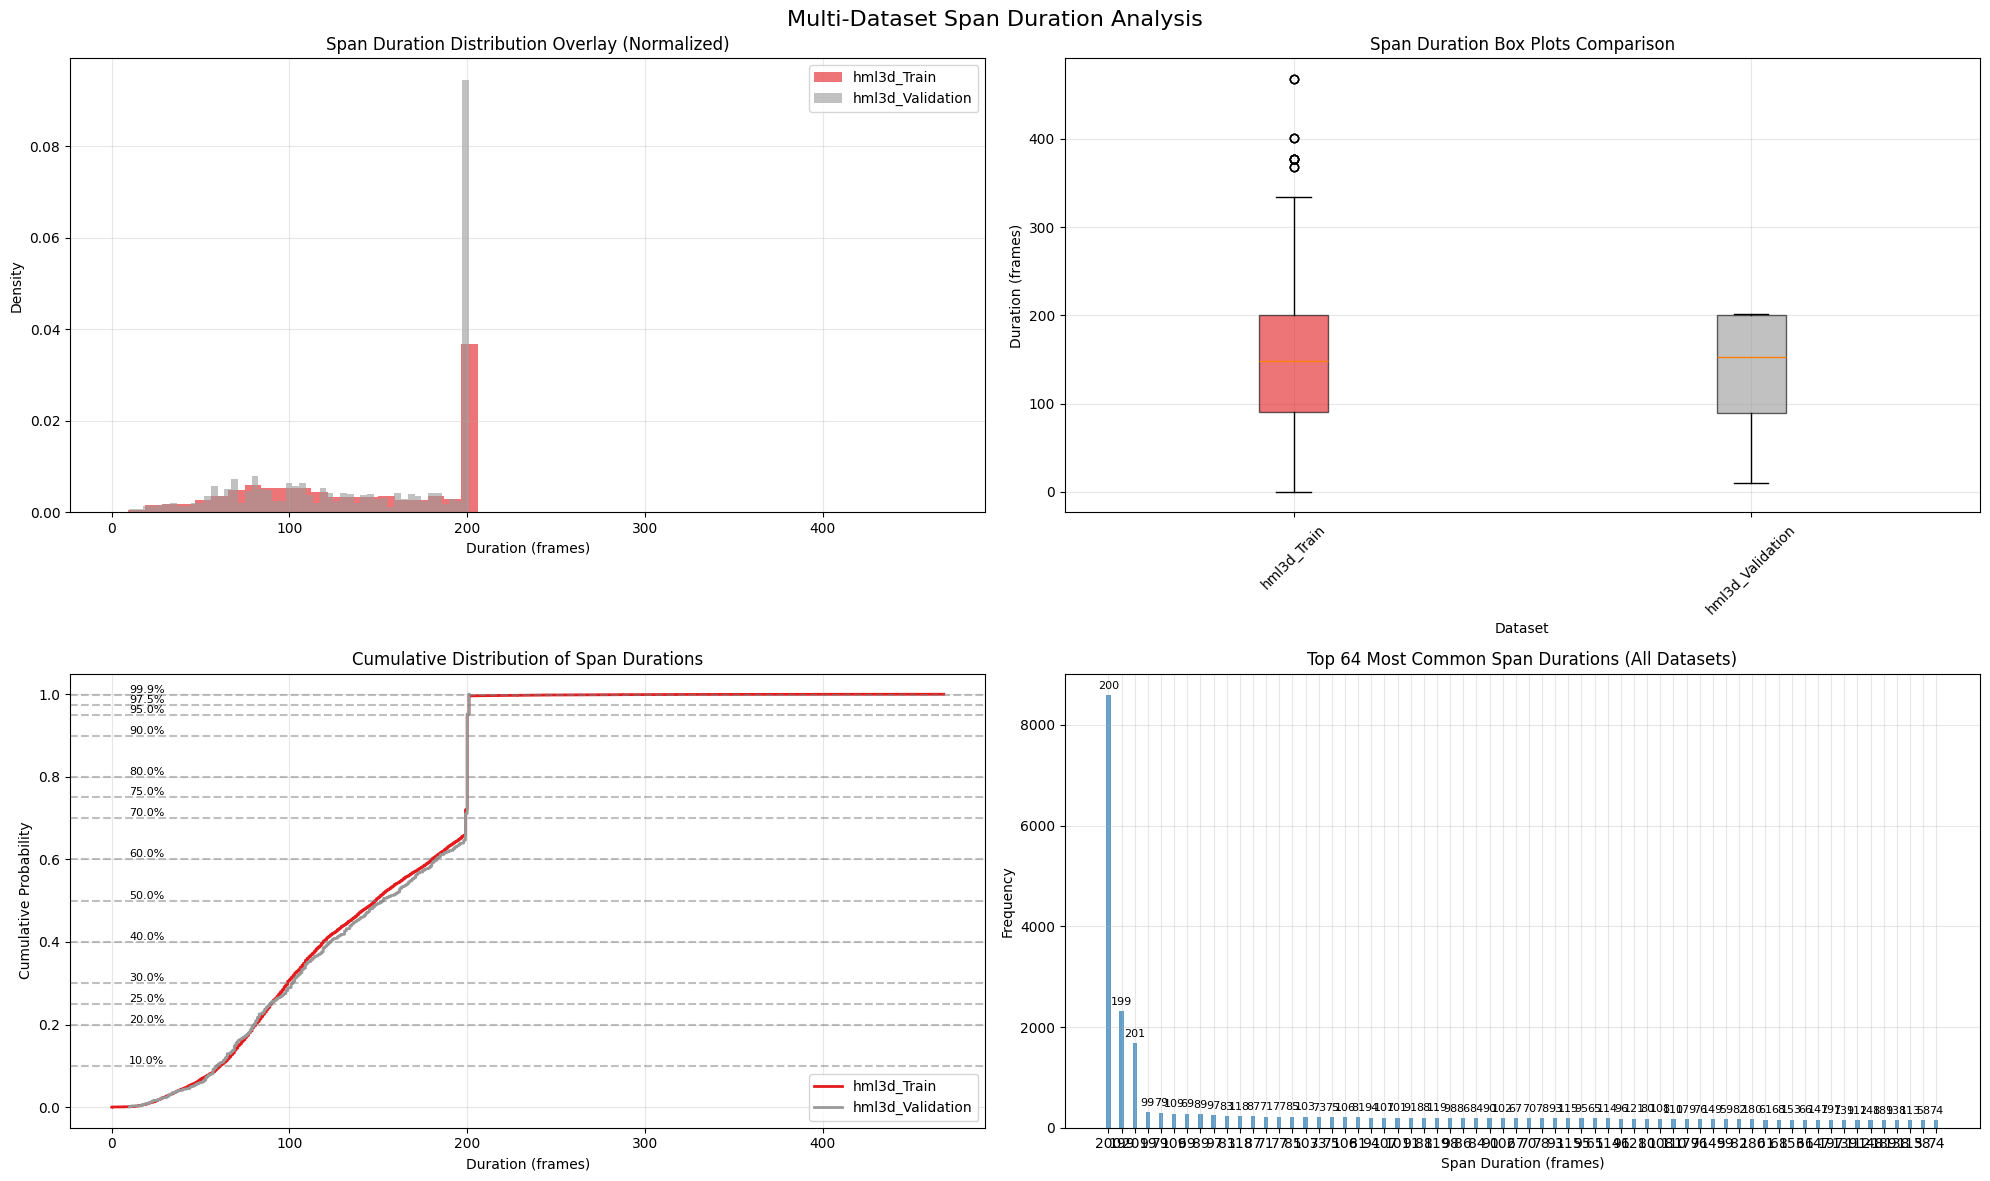


Most common spans: [(200, 8590), (199, 2315), (201, 1673), (99, 311), (79, 301), (109, 279), (69, 279), (89, 271), (97, 248), (83, 236), (118, 227), (87, 227), (71, 222), (77, 222), (85, 219), (103, 218), (73, 216), (75, 215), (106, 212), (81, 208), (94, 201), (107, 201), (101, 198), (91, 198), (88, 197), (119, 197), (98, 195), (86, 194), (84, 194), (90, 192), (102, 191), (67, 191), (70, 189), (78, 189), (93, 189), (115, 188), (95, 188), (65, 186), (114, 185), (96, 183), (121, 182), (80, 179), (108, 178), (110, 174), (179, 174), (76, 168), (149, 167), (59, 165), (82, 165), (180, 164), (61, 162), (68, 160), (153, 159), (66, 159), (147, 159), (197, 158), (139, 156), (112, 156), (148, 156), (189, 152), (138, 150), (113, 149), (58, 149), (74, 149)]
Recommended spans: [61, 81, 90, 99, 119, 149, 180, 199, 200, 201, 288]


In [71]:
analyses_list = [train_analysis, validation_analysis]

results = plot_multiple_datasets_spans_overlay(
    analyses_list=analyses_list,
    top_n_spans=64,
    figsize=(20, 12)
)

print("\nMost common spans:", results['most_common_spans'])
print("Recommended spans:", results['recommended_spans'])